This is a working notebook for a class that has methods for:
0. Loading all images of interest
0. Replacing all pixels of a specified range of hues to isoluminant grey
0. Getting VGG responses to those images, and saving them.

These responses can later be used by trained encoding models to predict the difference in activity due to single hues in natural images.

The `prep_data_and_fit_neurons` function takes a dataframe containing the outputs of this file.

In [1]:
import rpy2

In [2]:
# compute
import numpy as np
import pandas as pd
import keras

# data io
import glob
import deepdish as dd
import sys
sys.path.append('../')

# image
# import cv2

# plot
import matplotlib.pyplot as plt
%matplotlib inline

# spykes
# from spykes.neuropop import NeuroPop
# from spykes.neurovis import NeuroVis

# stats
from scipy.stats import circmean

# machine learning
import xgboost as xgb

# local
from V4pyutils import *

# from MLencoding import MLencoding

from sklearn.manifold import TSNE, MDS, SpectralEmbedding
from tqdm import tqdm
# from hyperopt import fmin, hp, Trials, tpe, STATUS_OK


Using TensorFlow backend.
/opt/anaconda/anaconda2/envs/V4/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda/anaconda2/envs/V4/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 1: 
  warnings.warn(x, RRuntimeWarning)
/opt/anaconda/anaconda2/envs/V4/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In value[[3L]](cond) :
  warnings.warn(x, RRuntimeWarning)
/opt/anaconda/anaconda2/envs/V4/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
 
  warnings.warn(x, RRuntimeWarning)
/opt/anaconda/anaconda2/envs/V4/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  "getThreads" not available for .C() for package "RevoUtilsMath"

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda/anaconda2/envs/V4/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 2: 
  warnings.warn

Load dataframe with all the metadata for the images we have neural recordings for:

In [3]:
nat_df = pd.read_pickle('../02-preprocessed_data/M3/merged_nat_data_across_sessions')

Load and image and print it

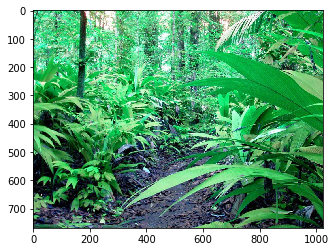

In [4]:
I = get_image('../V4pydata', nat_df.loc[0]['im.path'] , nat_df.loc[0]['im.name'])
plt.imshow(I)

plt.show()

Build hue-replacing function.

In [5]:
from skimage.color import luv2rgb, rgb2luv

def replace_with_gray(I, hue_range, saturation = 0):
    """Replaces a range of hues with isoluminant grey. Uses the LUV color space, taking U,V to some percentage
    of their original values (set with 'saturation').
    
    Inputs:
    =======
    I = RGB image
    hue_range = (low_lim, high_lim), tuple of hue range (in radians, [-pi, pi]) to bring to grey. 
                Currently no support for intervals that include 0
    saturdation  = [0,1] """
    
    # Convert to Luv
    I = I.astype(np.float32)
    I *= 1./255
    Luv = rgb2luv(I)
    
    # Take down hue, keeping luminance
    just_lum = Luv.copy()
    just_lum[:,:,1:] = saturation * just_lum[:,:,1:]
    
    # get hues
    hue = np.arctan2(Luv[:,:,2], Luv[:,:,1])
    in_range = ((hue > hue_range[0]) & (hue < hue_range[1]))
            #take this 2d array to 3d
    in_range_3d = np.broadcast_to(in_range[:,:,np.newaxis],Luv.shape)

    # return [L,0,0] if in range, or original pixel if not
    Luv_prime = np.where(in_range_3d,just_lum, Luv)
    
    # Bring back to RGB
    I_prime =   luv2rgb(Luv_prime)*255
    
    # scale back upwards by 256 and round to recover (mad annoying that this is the case.)
    I_prime = I_prime.astype(np.uint8)
    
    return I_prime

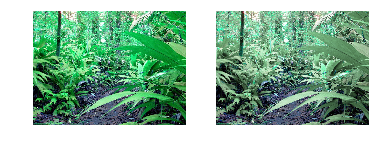

In [6]:
plt.plot(figsize=(24,10))
Ip = replace_with_gray(I,[2,2.5],saturation=0.5)
np.argwhere(np.isnan(Ip))
plt.subplot(121)
plt.imshow(I)
plt.axis('off')
plt.subplot(122)
plt.imshow(Ip)
plt.axis('off')
plt.savefig('CCN_figures/grey_demo.png',format='png', dpi = 400)
plt.show()


In [7]:
def get_nat_features_ari_hue_dropout(df, 
                     reject_conditions={'filters.in_screen_radius': True, 'filters.badfix' : False},
                     stimpath='../V4pydata',
                     radius=200, RF_block=14,
                     n_histogram_bins=16,
                     model_list=['histogram'], also_normal_feats = True,
                     saturation_levels = [0, 0.5, 0.6, 0.7, 0.8, 0.9],
                     non_image_features_list=None):
    """
    This is the master function to extract image features from
    a data frame that has image name and image path.
    
    saturation_levels = list of floats in range [0,1]. compute the VGG features for images with 
                                each hue bin taken to each saturation in the list
    """
    
    image_features = list()      # image features
    non_image_features = list()  # non-image features
    accepted_indices = list()

    if 'vggl8' in model_list:
        # Instantiate vgg models
        vgg_model_l8 = vgg_transfer_ari(n_pops=0)
    if 'vggl7' in model_list:    
        vgg_model_l7 = vgg_transfer_ari(n_pops=1)
    if 'vggl6' in model_list:    
        vgg_model_l6 = vgg_transfer_ari(n_pops=2)
    if 'vggl5' in model_list:    
        vgg_model_l5 = vgg_transfer_ari(n_pops=3)
        
    an = 1
    if also_normal_feats: an=0
        
    prev_impath, prev_imname = None, None

    # Loop through the data frame
    for fx in tqdm(df.index):

        # Check for reject conditions
        select = list()
        for k in reject_conditions.keys():
            select.append(df.loc[fx][k] == reject_conditions[k])
        select = np.all(select)

        
        if select == True:
            # Open image file
            impath = df.loc[fx]['im.path']
            imname = df.loc[fx]['im.name']
            if(impath != prev_impath or imname != prev_imname):
                I = get_image(stimpath=stimpath, impath=impath, imname=imname)
            prev_impath, prev_imname = impath, imname
            
                        # Check for missing image file
            if I is None: 
                continue

            # for each bin (including full images if an=0)
            for bn in range(an,n_histogram_bins+1):
                

                # Cut relevant fixation (maybe again)
                r, c = int(df.loc[fx]['predictors.row']), int(df.loc[fx]['predictors.col'])
                I_fix_ori = I[r-radius:r+radius, c-radius:c+radius, :]
                try:assert I_fix_ori.shape == (400,400,3)
                except AssertionError:
                    print(I_fix_ori.shape)
                    raise
                    
                #for each saturation
                z = 0
                for sat_level in saturation_levels:
                    # run once without removing any color
                    tag = '.full'
                    if bn > 0:
                        hue_range = np.array([bn-1, bn]).astype('float32') / n_histogram_bins*2*np.pi - np.pi
                        I_fix = replace_with_gray(I_fix_ori, hue_range, saturation = sat_level)
                        tag = '.sat_'+str(sat_level)+'_bin_'+ str(bn)
                    else:
                        #run once and only once for full images
                        if z>0: continue
                        z+=1
                        I_fix = I_fix_ori.copy()

                    # Grid image into blocks
                    Block = grid_image(I_fix, [4, 4])

                    this_image_feature = dict()
                    # Extract feature for desired image

                    if 'histogram' in model_list:
                        hue_image = get_hue_image(Block[RF_block]) 
                        #uncomment for histogram NOT weighted by saturation
#                         this_image_feature['hue.histogram'+tag] = \
#                            list(get_hue_histogram(hue_image, n_bins=n_histogram_bins))
                        this_image_feature['hue.histogram'+tag] = \
                           list(weighted_hue_histogram(Block[RF_block], n_bins=n_histogram_bins))
                            
                        this_image_feature['hue.mean'+tag] = circmean(hue_image)
                        this_image_feature = pd.Series(this_image_feature)

                    # Prepare the image for vgg input
                    I_fix_resize = cv2.resize(I_fix, (224,224)).astype('float32')
                    I_fix_for_vgg = preprocess_input( np.expand_dims(I_fix_resize, axis=0) )

                    if 'vggl8' in model_list:
                        this_image_feature['vgg.l8'+tag] = np.squeeze(vgg_model_l8.predict(I_fix_for_vgg))
                    if 'vggl7' in model_list:    
                        this_image_feature['vgg.l7'+tag] = np.squeeze(vgg_model_l7.predict(I_fix_for_vgg))
                    if 'vggl6' in model_list:    
                        this_image_feature['vgg.l6'+tag] = np.squeeze(vgg_model_l6.predict(I_fix_for_vgg))
                    if 'vggl5' in model_list:
                        this_image_feature['vgg.l5'+tag] = np.squeeze(vgg_model_l5.predict(I_fix_for_vgg))

                    # Accumulate non-image features
                    this_non_image_feature = df.loc[fx][non_image_features_list]

                    # Collect features in a list
                    image_features.append(this_image_feature)
                    non_image_features.append(this_non_image_feature)
                    accepted_indices.append(fx)

    # Put this round into a data frame
    nat_features = pd.DataFrame({'image_features': image_features, 
                                 'non_image_features': non_image_features,
                                 'accepted_indices': accepted_indices})
    return nat_features


In [8]:
non_image_features_list = ['predictors.col',
                           'predictors.row',
                           'predictors.trial',
                           'predictors.fixation', 
                           'predictors.out_sac_blink',
                           'predictors.in_sac_dur',
                           'predictors.fix_duration',
                           'predictors.prev_fix_duration',
                           'predictors.drift', 
                           'predictors.out_sac_dur',
                           'predictors.next_fix_duration']


# Compute predictive features for X matrix
nbins = 8

nat_features = get_nat_features_ari_hue_dropout(df=nat_df,
                                radius=200, RF_block=14,
                                n_histogram_bins=nbins, 
                                saturation_levels = [],
                                model_list=['histogram', ], also_normal_feats = True,
                                non_image_features_list=non_image_features_list)

  2%|▏         | 1288/77691 [00:05<06:09, 206.79it/s]


IndexError: tuple index out of range

In [ ]:
name = '../02-preprocessed_data/M3/hue_dropout_'+str(nbins)+\
                  'bins/precomputed_nat_features_funn_nat_features'
nat_features.to_pickle(name)

In [ ]:
nat_features.head(25)

In [ ]:
a = np.zeros(len(nat_features))
a[0::24] = 1
a[1::24] = 1
a[2::24] = 1
b = nat_features.iloc[a.astype(bool)]
pd.concat([b, zerosat],axis=0).reset_index(0).reset_index(0).sort_values(
                        by=['accepted_indices','level_0'],inplace =False).drop(['index','level_0'],axis=1).reset_index(drop = True)

In [ ]:
name = '/home/klab/Projects/02-V4py/V4py/'+\
                '02-preprocessed_data/M3/hue_dropout_8bins/precomputed_nat_features_hue_dropout_1'
zerosat = pd.read_pickle(name)
zerosat.head()

In [ ]:
# segment and save separately for memory issues

for i in range(nbins):
    a = nat_features.iloc[i::nbins]
    name = '../02-preprocessed_data/M3/hue_dropout_'+str(nbins)+
                  'bins/precomputed_nat_features_hue_'+ str(i+1)
        
    a.to_pickle(name)
    print(len(a), name)

In [ ]:
# segment and save separately for memory issues

for i in range(nbins):
    a = np.zeros(len(nat_features))
    a[i*3::24] = 1
    a[i*3+1::24] = 1
    a[i*3+2::24] = 1
    b = nat_features.iloc[a.astype(bool)]
        
    dir_path = '/home/klab/Projects/02-V4py/V4py/02-preprocessed_data/M3/hue_dropout_'+str(nbins)+ 'bins/'
    name = 'precomputed_nat_features_hue_dropout_'+ str(i+1)
    zerosat = pd.read_pickle(dir_path+name)
    
    this_bin_df = pd.concat([b, zerosat],axis=0).reset_index(0).reset_index(0).sort_values(
                            by=['accepted_indices','level_0'],inplace =False).drop(
                        ['index','level_0'],axis=1).reset_index(drop = True)


    name = 'precomputed_nat_features_desat_huebin_'+ str(i+1)
    this_bin_df.to_pickle(dir_path+name)
    print(len(this_bin_df), name)
    print(this_bin_df.head())

In [ ]:
dir_path = '/home/klab/Projects/02-V4py/V4py/02-preprocessed_data/M3/hue_dropout_'+str(nbins)+ 'bins/'
name = 'precomputed_nat_features_hue_dropout_0'
fullsat = pd.read_pickle(dir_path+name)

In [ ]:
fullsat.head(20)

## Test the pipeline

We'll build a method that, for any single image, produces responses and V4 predictions. We'll compare the predicted response as a function of tweaks to the `replace_with_grey` function.

In [ ]:
h5path = '../V4pydata/H5data/M3/'
data = pd.read_excel('/home/klab/Projects/02-V4py/V4py/V4pydata/natural_artificial.xlsx')
data_M3 = data[data['Animal']=='M3']

art_df = pd.read_pickle('../02-preprocessed_data/M3/merged_art_data_across_sessions')

df_neurons = pd.read_pickle('../02-preprocessed_data/M3/data_to_combine_across_sessions')

nat_df = pd.read_pickle('../02-preprocessed_data/M3/merged_nat_data_across_sessions')

First train a model

In [ ]:
def train_model(df_neurons, df_data, features_location, image_feature, model = 'GLM_poisson',
                        which_neurons = 'all', joint = True,
                        verbose = 0):
    """
    Just trains a classifier and returns it
    
    
    Inputs
    ======
    df_neurons = dataframe with neural data
    df_data = dataframe with all data. Must contain 'session_number' column
    features_location = path to results of `get_nat_features_ari_hue_dropout`. 
                        assumes name "'precomputed_nat_features_hue_dropout_' + str(_)"
    image_feature = which layer of the VGG to use
    model = which model to train. Either 'fitted_keras' or an sklearn-style model object
    which_neurons = a list of ints of which neurons to use
    joint = To use just image features or other things too (fixation statistics, ...)
    compare_to_response = whether to subtract the responses from the actual neural response rather than the
                    predicted response. 
                    WARNING perhaps unjustified, needs evaluation
    nbins = number of color bins used to construct different images. 
            same as used when `get_nat_features_ari_hue_dropout` was called
        
    
    Outputs
    =======
    classifier
    """
    assert model in ['GLM_poisson','fitted_keras']

    
    if which_neurons is 'all':
        which_neurons = np.arange(len(df_neurons['name']))
    elif isinstance(which_neurons,int):
        which_neurons = [which_neurons]
    
    # build model        
    if image_feature == 'vgg.l8':
        vgg_model= vgg_transfer_ari(n_pops=0)
        n_nodes = 1011
        if not joint: n_nodes = 1000
    elif image_feature == 'vgg.l7':
        vgg_model= vgg_transfer_ari(n_pops=1)
        n_nodes = 4107
        if not joint: n_nodes = 4096
    elif image_feature == 'vgg.l6':
        vgg_model= vgg_transfer_ari(n_pops=2)
        n_nodes = 4107
        if not joint: n_nodes = 4096
    elif image_feature == 'vgg.l5':
        vgg_model= vgg_transfer_ari(n_pops=3)
        n_nodes = 25099
        if not joint: n_nodes = 25088
            
    n_neurons = len(df_neurons['name'])
    assert n_neurons == 90
    
    #things to save when we look at unmodified images
    model_instances = [0]*n_neurons
    mean_responses_to_full_images = np.zeros((n_neurons,))
    
    
    this_image_feature = image_feature + '.full'
    file_to_load = features_location + str(0)
    if verbose>0:
        print('... loading '+file_to_load)
    nat_features = pd.read_pickle(file_to_load)
            
    for neuron_id, neuron_name in tqdm(enumerate(df_neurons['name'])):

        if neuron_id not in which_neurons:
            continue


        ### Get X and Y data for responses to full images

        # Extract session numbers
        sessions_of_interest = df_neurons.loc[neuron_id]['nat_sessions']

        df_sessions_of_interest = df_data.loc[df_data['session.number'].isin(sessions_of_interest) & \
                                             df_data.index.isin(nat_features['accepted_indices'])]
        #-----------------
        # Get covariates
        #-----------------
        # Select sessions of interest
        indices_of_interest = np.array(df_sessions_of_interest.index)

        nat_features_of_interest = \
            nat_features.loc[nat_features['accepted_indices'].isin(indices_of_interest)]

        # Convert everything to array

        n_samples = len(nat_features_of_interest)

        # Image features
        n_features = len(nat_features_of_interest['image_features']\
                         [nat_features_of_interest.index[0]][this_image_feature])

        image_features_array = np.zeros((n_samples, n_features))
        image_features_list = [nat_features_of_interest['image_features'][k][this_image_feature] \
                               for k in nat_features_of_interest.index]
        assert len(image_features_list) == n_samples

        for k in range(n_samples):
            image_features_array[k, :] = image_features_list[k]

        # Non-image features
        n_features = np.shape(nat_features_of_interest['non_image_features']\
                              [nat_features_of_interest.index[0]].values)[0]
        non_image_features_array = np.zeros((n_samples, n_features))
        non_image_features_list = [nat_features_of_interest['non_image_features'][k].values \
                               for k in nat_features_of_interest.index\
                              if this_image_feature in nat_features_of_interest['image_features'][k].keys()]
        for k in range(n_samples):
            non_image_features_array[k, :] = non_image_features_list[k]

        # Concatenate
        if joint:
            X = np.concatenate((image_features_array, 
                               non_image_features_array), 
                              axis=1)
        else:
            X = image_features_array



        # Labels and number of folds for stratified CV
        labels = df_sessions_of_interest['session.number']
        n_cv = np.size(np.unique(sessions_of_interest))
        labels = [] if n_cv == 1 else labels
        n_cv = 10 if n_cv == 1 else n_cv


        Y = df_sessions_of_interest[neuron_name].values

        #### Fit model and predict

        if model is not 'fitted_keras':   
            my_model = keras_GLM_optimized(input_dim = n_nodes)
            # can't used fitted keras to predict for images because it was fit on those!! will be overfit
            Yt_hat, pseudo_R2 = fit_cv(X, Y,
                                      stratify_by_labels=labels,
                                      n_cv=n_cv, epochs=50,batch_size=128,
                                      algorithm= model,model = my_model,
                                      verbose=verbose)

            model_instance = fit(X, Y, algorithm=model,epochs=50,batch_size=128,)

        else:
            model_instance = keras_GLM(n_nodes, 100)
            if joint:
                model_instance.load_weights('../02-preprocessed_data/M3/fit_models/'\
                                       +str(neuron_id)+'_'+neuron_name+'_l6_joint')
            else:
                model_instance.load_weights('../02-preprocessed_data/M3/fit_models/'\
                                       +str(neuron_id)+'_'+neuron_name+'_l6_image')

            if not compare_to_response:
                Yt_hat = model_instance.predict(X)

        #save for when we predict responses for other images
        model_instances[neuron_id] = model_instance
    
    return model_instances

In [ ]:
model_instances = train_model(df_neurons, nat_df, '../02-preprocessed_data/M3/precomputed_nat_features_hue_dropout_',
                        image_feature = 'vgg.l6', model = 'GLM_poisson',
                        which_neurons = 4, joint = True)

Now we'll make a function that takes an image and model and returns a prediction

In [ ]:
def grey_and_get_VGG(df, fixation_number, hue_range, saturation=0, show_fix = False,
                    loaded_vgg = None,
                     reject_conditions={'filters.in_screen_radius': True, 'filters.badfix' : False},
                     stimpath='../V4pydata', radius=200, RF_block=14,):
    """Greys out a hue range (with optional partial desaturation) of a specified fixation and gives l6 VGG responses
    and non-image features"""
    ##### Get the image #######
    
    # Check for reject conditions
    select = list()
    reject_conditions = {'filters.in_screen_radius': True, 'filters.badfix' : False}
    for k in reject_conditions.keys():
        select.append(df.loc[fixation_number][k] == reject_conditions[k])
    select = np.all(select)

    prev_impath, prev_imname = None, None
        
    if select != True: raise AssertionError('This fixation was marked as invalid.')
        
    # Open image file
    impath = df.loc[fixation_number]['im.path']
    imname = df.loc[fixation_number]['im.name']
    if(impath != prev_impath or imname != prev_imname):
        I = get_image(stimpath=stimpath, impath=impath, imname=imname)
    prev_impath, prev_imname = impath, imname
            
                # Check for missing image file
    if I is None: 
        raise IOError('No image found.')

    # Cut relevant fixation (maybe again)
    r, c = int(df.loc[fixation_number]['predictors.row']), int(df.loc[fixation_number]['predictors.col'])
    I_fix = I[r-radius:r+radius, c-radius:c+radius, :]

        
    ##### Replace with grey ######
    I_fix = replace_with_gray(I_fix, hue_range, saturation)
    if show_fix:
        plt.imshow(I_fix)
        plt.show()
                    
    # Grid image into blocks
    Block = grid_image(I_fix, [4, 4])

    this_image_feature = dict()
                  
    #### Get responses  ######
    if loaded_vgg== None:
        vgg_model_l6 = vgg_transfer_ari(n_pops=2)
    else:
        vgg_model_l6 = loaded_vgg
        
    # Prepare the image for vgg input
    I_fix_resize = cv2.resize(I_fix, (224,224)).astype('float32')
    I_fix_for_vgg = preprocess_input( np.expand_dims(I_fix_resize, axis=0) )

    # Compute feed forward pass

    this_image_feature = np.squeeze(vgg_model_l6.predict(I_fix_for_vgg))

    # Accumulate non-image features
    this_non_image_feature = df.loc[fixation_number][non_image_features_list]
    
    X = np.concatenate((this_image_feature, 
                   this_non_image_feature), 
                  axis=0)

    return np.reshape(X, (1,X.shape[0]))


Here's the pipeline

In [ ]:
fix_no = 1
neuron_id = 4
vgg_model_l6 = vgg_transfer_ari(n_pops=2)
hue_range = [2,2.5]


In [ ]:
activation = grey_and_get_VGG(nat_df, fix_no, hue_range, saturation=0, show_fix = True, loaded_vgg=vgg_model_l6)

response = model_instances[neuron_id].predict(activation)

In [ ]:
response

Let's plot as a function of saturation for this image

In [ ]:
resp = []
for sat in tqdm(np.arange(0,1.05,0.05)):
    activation = grey_and_get_VGG(nat_df, fix_no, hue_range, saturation=sat, show_fix = False, loaded_vgg=vgg_model_l6)
    response = np.squeeze(model_instances[neuron_id].predict(activation))
    resp.append(response)

In [ ]:
plt.plot(np.arange(0,1.05,0.05),resp)
plt.xlabel('Saturation level of hue range')

Now let's see how this changes as a function of window

In [ ]:
resp2 = []
inc = 0.05
for lim in tqdm(np.arange(2,3+inc,inc)):
    hue_range = [2,lim]
    activation = grey_and_get_VGG(nat_df, fix_no, hue_range, saturation=0, show_fix = False, loaded_vgg=vgg_model_l6)
    response = np.squeeze(model_instances[neuron_id].predict(activation))
    resp2.append(response)


In [ ]:
plt.plot(np.arange(0,1+inc,inc),resp2)
plt.xlabel('Window size of hues')

### Compute hue histograms 

In [ ]:
def get_nat_features_imname(df, 
                     reject_conditions={'filters.in_screen_radius': True, 'filters.badfix' : False},
                     stimpath='../V4pydata',
                     radius=200, RF_block=14,
                     n_histogram_bins=16,
                    
                     non_image_features_list=None):
    """
    This is the master function to extract image features from
    a data frame that has image name and image path
    """
    
    image_features = list()      # image features
    non_image_features = list()  # non-image features
    accepted_indices = list()
        
    prev_impath, prev_imname = None, None

    # Loop through the data frame
    for fx in tqdm(df.index):

        # Check for reject conditions
        select = list()
        for k in reject_conditions.keys():
            select.append(df.loc[fx][k] == reject_conditions[k])
        select = np.all(select)

        
        if select == True:
            # Open image file
            impath = df.loc[fx]['im.path']
            imname = df.loc[fx]['im.name']
           
            non_image_features.append(impath+imname)
            accepted_indices.append(fx)

    # Put this round into a data frame
    nat_features = pd.DataFrame({
                                 'non_image_features': non_image_features,
                                 'accepted_indices': accepted_indices})
    return nat_features


In [ ]:
non_image_features_list = ['predictors.col',
                           'predictors.row',
                           'predictors.trial',
                           'predictors.fixation', 
                           'predictors.out_sac_blink',
                           'predictors.in_sac_dur',
                           'predictors.fix_duration',
                           'predictors.prev_fix_duration',
                           'predictors.drift', 
                           'predictors.out_sac_dur',
                           'predictors.next_fix_duration']


# Compute predictive features for X matrix
nbins = 8
from tqdm import tqdm

nat_features = get_nat_features_imname(df=nat_df,
                                radius=200, RF_block=14,
                                n_histogram_bins=nbins, 
                                non_image_features_list=non_image_features_list)

In [ ]:
name = '../02-preprocessed_data/M3/precomputed_nat_features_imname'
nat_features.to_pickle(name)

In [ ]:
nat_features['imname'] = nat_features['non_image_features']

In [ ]:
nat_features.drop(['non_image_features',],axis=1)